In [1]:
import pickle
import pathlib

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
DATA_DIR = pathlib.Path.cwd()
clean_data_path = DATA_DIR / 'data' / 'processed' / 'ames_clean.pkl'
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

model_data = data.copy()
# data.info()

In [3]:
## soma de todos os porches - erro aumenta
# model_data['Porch'] = model_data['Open.Porch.SF'] + model_data['Enclosed.Porch'] + model_data['X3Ssn.Porch'] + model_data['Screen.Porch']
# model_data = model_data.drop(columns=['Open.Porch.SF', 'Enclosed.Porch', 'X3Ssn.Porch', 'Screen.Porch'])

# soma de todos os banheiros - erro aumenta
# soma de banheiros por tipo - erro não altera
model_data['Full.Bath'] += model_data['Bsmt.Full.Bath']
model_data['Half.Bath'] += model_data['Bsmt.Half.Bath']
model_data = model_data.drop(columns=['Bsmt.Full.Bath', 'Bsmt.Half.Bath'])

# soma de todos os 'pes' quadrados (sem porch) - erro diminui
model_data['Total.Liv.SF'] = model_data['X1st.Flr.SF'] + model_data['X2nd.Flr.SF'] + model_data['Gr.Liv.Area'] + model_data['BsmtFin.SF.1'] + model_data['BsmtFin.SF.2'] + model_data['Low.Qual.Fin.SF'] + model_data['Bsmt.Unf.SF']
model_data = model_data.drop(columns=['X1st.Flr.SF', 'X2nd.Flr.SF', 'Gr.Liv.Area', 'BsmtFin.SF.1', 'BsmtFin.SF.2', 'Low.Qual.Fin.SF', 'Bsmt.Unf.SF'])

# sem "Kitchen.AbvGr", "Land.Slope", "Paved.Drive" - erro aumenta
# variaveis com baixa diferenca entre os dados - erro diminui
model_data = model_data.drop(columns=["Pool.Area", "Misc.Val"])

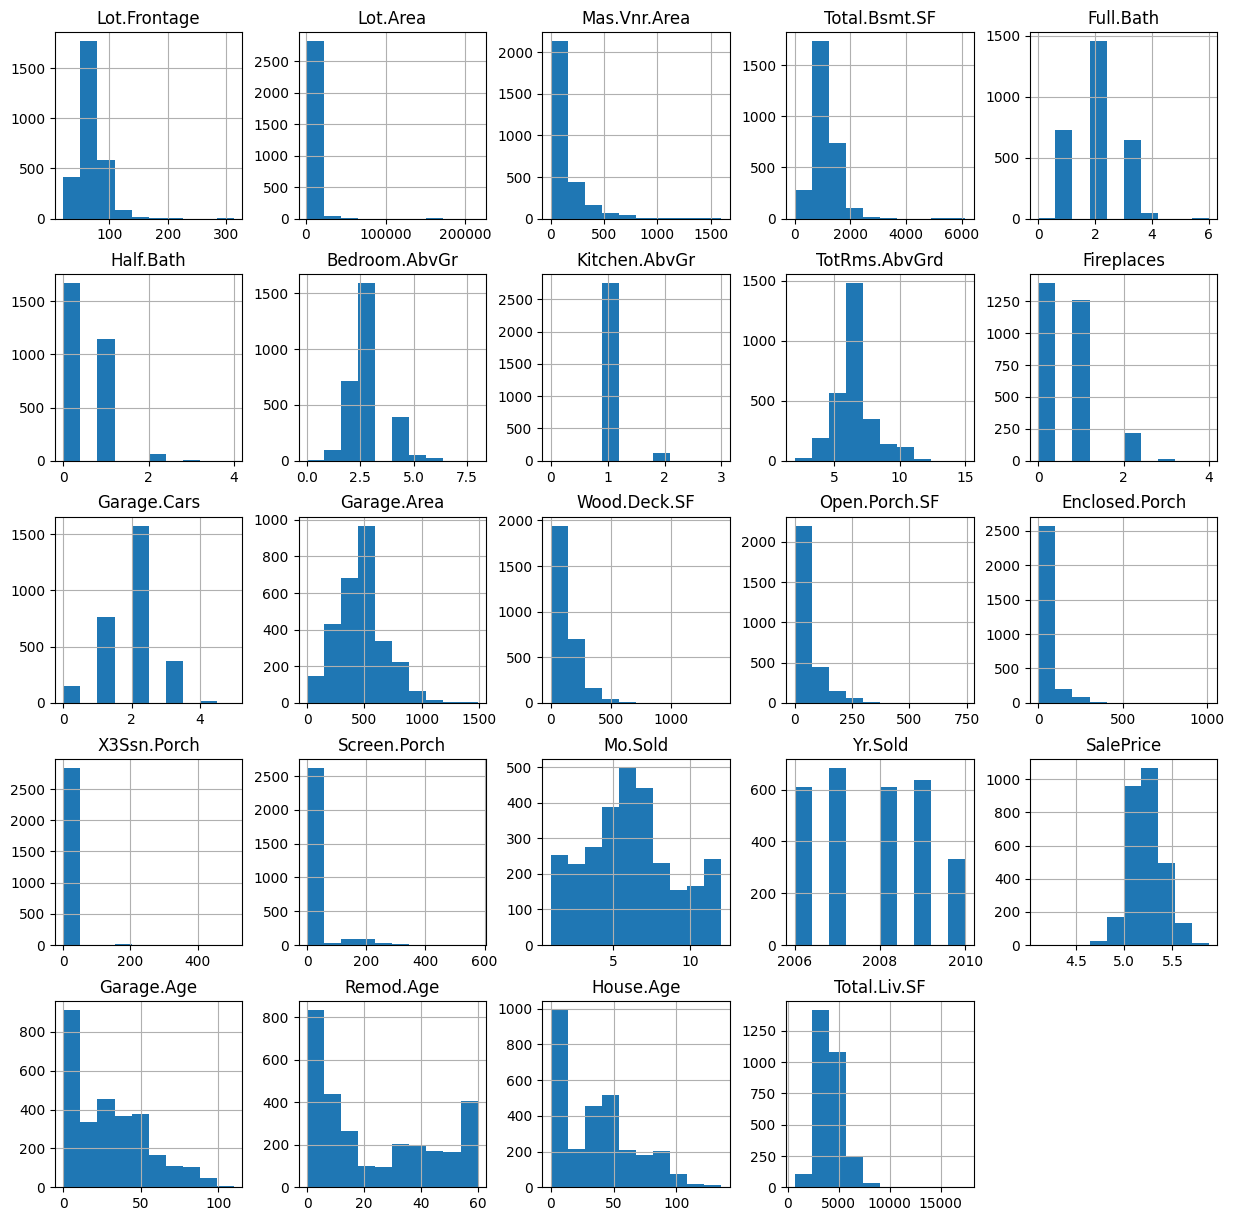

In [4]:
data = model_data
data.hist(figsize=(15,15))
print()

In [5]:

# -------------- Encode Ordinal -------------- #
categorical_columns = []
ordinal_columns = []
for col in model_data.select_dtypes('category').columns:
    if model_data[col].cat.ordered:
        ordinal_columns.append(col)
    else:
        categorical_columns.append(col)

# -------------- Factorize -------------- #
for col in ordinal_columns:
    codes, _ = pd.factorize(data[col], sort=True)
    model_data[col] = codes

# -------------- One Hot Encoding -------------- #
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data, drop_first=True)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()

# -------------- Should have helped with linearRegression errors -------------- #
model_data = pd.get_dummies(model_data, drop_first=True)
for cat in categorical_columns:
    dummies = []
    for col in model_data.columns:
        if col.startswith(cat + "_"):
            dummies.append(f'"{col}"')
    dummies_str = ', '.join(dummies)

In [6]:
# We're using ridge because not all versions of python work perfectly with linearRegression
from sklearn.linear_model import Ridge 

X = model_data.drop(columns=['SalePrice']).copy()
y = model_data['SalePrice'].copy()

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

model = Ridge()
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

RMSE = np.sqrt(mean_squared_error(ytest, ypred))
print(f'RMSE is {RMSE:.2f}')

error_percent = 100 * (10**RMSE - 1)
print(f'Average error is {error_percent:.2f}%')

RMSE is 0.06
Average error is 14.47%


In [7]:
# We're using ridge because not all versions of python work perfectly with linearRegression
from sklearn.linear_model import Ridge 

X = model_data.drop(columns=['SalePrice']).copy()
y = model_data['SalePrice'].copy()

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

model = Ridge()
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

RMSE = np.sqrt(mean_squared_error(ytest, ypred))
print(f'RMSE is {RMSE:.2f}')

error_percent = 100 * (10**RMSE - 1)
print(f'Average error is {error_percent:.2f}%')

RMSE is 0.06
Average error is 14.47%


In [8]:
from sklearn.model_selection import GridSearchCV

# 'alpha', 'copy_X', 'fit_intercept', 'max_iter', 'positive', 'random_state', 'solver', 'tol'
param_grid = {
    # 'alpha': [0.01, 1, 2, 4, 5, 6, 10],
    'max_iter': [1, 2, 3, 4],
    'fit_intercept': [True, False], 
    'tol': [1e-5, 1e-4, 1e-3, 1e-2] 
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(Xtrain, ytrain)
print("Best Hyperparameters:", grid_search.best_params_)

best_rf_classifier = grid_search.best_estimator_
ypred = best_rf_classifier.predict(Xtest)

RMSENEW = np.sqrt(mean_squared_error(ytest, ypred))
print(f'New RMSE is {RMSE:.2f}, better by {RMSE-RMSENEW:.2f}')
error_percent_new = 100 * (10**RMSE - 1)
print(f'New average error is {error_percent_new:.2f}%, better by {error_percent-error_percent_new:.2f}%')


Best Hyperparameters: {'fit_intercept': True, 'max_iter': 1, 'tol': 1e-05}
New RMSE is 0.06, better by 0.00
New average error is 14.47%, better by 0.00%


-----------------------------


In [9]:
from sklearn.linear_model import LinearRegression

X = model_data.drop(columns=['SalePrice']).copy()
y = model_data['SalePrice'].copy()

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

model_LR = LinearRegression()
model_LR.fit(Xtrain, ytrain)
ypred_LR = model_LR.predict(Xtest)

RMSE = np.sqrt(mean_squared_error(ytest, ypred_LR))
print(f'RMSE is {RMSE:.2f}')

error_percent = 100 * (10**RMSE - 1)
print(f'Average error is {error_percent:.2f}%')

RMSE is 0.06
Average error is 14.50%


In [10]:
from sklearn.linear_model import Lasso

X = model_data.drop(columns=['SalePrice']).copy()
y = model_data['SalePrice'].copy()

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

model_Las = Lasso()
model_Las.fit(Xtrain, ytrain)
ypred_Las = model_Las.predict(Xtest)

RMSE = np.sqrt(mean_squared_error(ytest, ypred_Las))
print(f'RMSE is {RMSE:.2f}')

error_percent = 100 * (10**RMSE - 1)
print(f'Average error is {error_percent:.2f}%')

RMSE is 0.10
Average error is 26.80%
